In [52]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

pd.options.display.max_columns = 120


In [53]:
def load_data(file_path):
    """Load data from a CSV file into a pandas DataFrame."""
    return pd.read_csv(file_path)

In [ ]:
train_dir = Path("../datasets/NR_split_on_skiers/train_val") 
train_files = list(train_dir.glob("*.csv"))
print(f"Training files: {len(train_files)}")

test_dir = Path("../datasets/NR_split_on_skiers/test")
test_files = list(test_dir.glob("*.csv"))
print(f"Test files: {len(test_files)}")     

Training files: 1
Test files: 1


In [69]:
info_columns = ['tt_s', 'Lap', 'Gear', 'ns1:LatitudeDegrees', 'ns1:LongitudeDegrees', 'Sport'] 
feature_columns_pole_data = ['speed_kmph', 'power_w', 'frequency_ppm', 'thrust_left_ms', 'thrust_right_ms', 'impulse_left_ns', 'impulse_right_ns', 'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n']
feature_columns_gnss = ['ns1:AltitudeMeters', 'ns2:Speed', 'ns2:RunCadence', 'ns2:Watts']
output_col = "Gear"
feature_columns = feature_columns_pole_data + feature_columns_gnss

In [70]:
dfs = [load_data(file) for file in train_files]
test_dfs = [load_data(file) for file in test_files]

def make_sure_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

dfs = [make_sure_numeric(df, feature_columns_gnss + feature_columns_pole_data) for df in dfs]
test_dfs = [make_sure_numeric(df, feature_columns_gnss + feature_columns_pole_data) for df in test_dfs]

In [71]:
# set gear 2.0V and 2.0H to 2
for df in dfs + test_dfs:
    df['Gear'] = df['Gear'].replace({'2.0V': '2', '2.0H': '2'})


In [72]:
def add_incline_from_altitude(df):
    df = df.sort_values(by='tt_s').reset_index(drop=True)
    df['incline'] = df['ns1:AltitudeMeters'].diff().fillna(0)
    return df

dfs = [add_incline_from_altitude(df) for df in dfs]
test_dfs = [add_incline_from_altitude(df) for df in test_dfs]

# normalize incline with mean and std from training data
all_incline = pd.concat([df['incline'] for df in dfs])
incline_mean = all_incline.mean()
incline_std = all_incline.std()

for df in dfs:
    df['incline'] = (df['incline'] - incline_mean) / incline_std

for df in test_dfs:
    df['incline'] = (df['incline'] - incline_mean) / incline_std
feature_columns.append('incline')
# remove alitude column
feature_columns.remove('ns1:AltitudeMeters')

In [73]:
def _stable_indices(y, n=2):
    """Return positional indices where the label has been stable for n before and n after."""
    y = y.reset_index(drop=True)
    idx = []
    for i in range(n, len(y) - n):
        c = y.iloc[i]
        # use iloc for positional comparisons
        if all(y.iloc[i - j] == c and y.iloc[i + j] == c for j in range(1, n + 1)):
            idx.append(i)
    return idx

def accuracy_when_stable_gear(y, pred, n=2):
    y = y.reset_index(drop=True)
    pred = np.asarray(pred)
    idx = _stable_indices(y, n)
    if len(idx) == 0:
        return np.nan
    return np.mean(y.iloc[idx].values == pred[idx])

def classification_report_when_stable_gear(y, pred, n=2):
    y = y.reset_index(drop=True)
    pred = np.asarray(pred)
    idx = _stable_indices(y, n)
    if len(idx) == 0:
        return "No stable segments found."
    return classification_report(y.iloc[idx], pred[idx], labels=ALL_LABELS, zero_division=0)

def confusion_matrix_when_stable_gear(y, pred, n=2):
    y = y.reset_index(drop=True)
    pred = np.asarray(pred)
    idx = _stable_indices(y, n)
    if len(idx) == 0:
        return None
    return confusion_matrix(y.iloc[idx], pred[idx], labels=ALL_LABELS)

In [74]:
train_df = pd.concat(dfs, ignore_index=True)
print(f"Training data shape: {train_df.shape}")
test_df = pd.concat(test_dfs, ignore_index=True)
print(f"Test data shape: {test_df.shape}")

Training data shape: (10952, 23)
Test data shape: (2738, 23)


In [75]:
def XY(df, feature_columns):
    X = df[feature_columns]
    Y = df[output_col]
    return X, Y

In [76]:
# Uncomment to not use the engineered features
feature_columns = feature_columns_pole_data + feature_columns_gnss
# feature_columns.append('Variant')
feature_columns.append('incline')
feature_columns.remove('ns1:AltitudeMeters')

X_train, y_train = XY(train_df, feature_columns)
X_test, y_test = XY(test_df, feature_columns)

In [77]:
def make_window_for_cnn(X, y, window_size=5):
    half_window = window_size // 2
    X_padded = np.pad(X, ((half_window, half_window), (0, 0)), mode='edge')
    X_windows = np.array([X_padded[i:i + window_size] for i in range(len(X))])
    return X_windows, y.values

In [78]:
X_train_seq, y_train_seq = make_window_for_cnn(X_train.values, y_train, window_size=5)
X_test_seq, y_test_seq = make_window_for_cnn(X_test.values, y_test, window_size=5)

In [79]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_seq)
y_test_enc  = le.transform(y_test_seq)

n_classes  = len(le.classes_)
n_features = X_train_seq.shape[-1]

In [80]:
def make_cnn(window, n_features, n_classes):
    inp = layers.Input(shape=(window, n_features))   # (T, F)
    x = layers.Conv1D(64, kernel_size=3, padding='causal', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(64, kernel_size=3, padding='causal', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)          # downsample time

    x = layers.Conv1D(128, kernel_size=3, padding='causal', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = make_cnn(5, n_features, n_classes)

es = callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor='val_loss')
rlr = callbacks.ReduceLROnPlateau(patience=4, factor=0.5)

history = model.fit(
    X_train_seq, y_train_enc,
    validation_split=0.15,  # (or GroupKFold to avoid skier leakage)
    epochs=60, batch_size=256,
    callbacks=[es, rlr], 
    verbose=1
)

Epoch 1/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7737 - loss: 0.6180 - val_accuracy: 0.8205 - val_loss: 1.0585 - learning_rate: 0.0010
Epoch 2/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8474 - loss: 0.4346 - val_accuracy: 0.7888 - val_loss: 0.9093 - learning_rate: 0.0010
Epoch 3/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8591 - loss: 0.3782 - val_accuracy: 0.8150 - val_loss: 0.7213 - learning_rate: 0.0010
Epoch 4/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8722 - loss: 0.3503 - val_accuracy: 0.8235 - val_loss: 0.6313 - learning_rate: 0.0010
Epoch 5/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8782 - loss: 0.3218 - val_accuracy: 0.8466 - val_loss: 0.5363 - learning_rate: 0.0010
Epoch 6/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8867 - loss: 0.2978 - val_accuracy: 0.8503 - val_loss: 0.4746 - learning_rate: 0.0010
Epoch 7/60
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8919 - loss: 0.2796 - val_accuracy: 

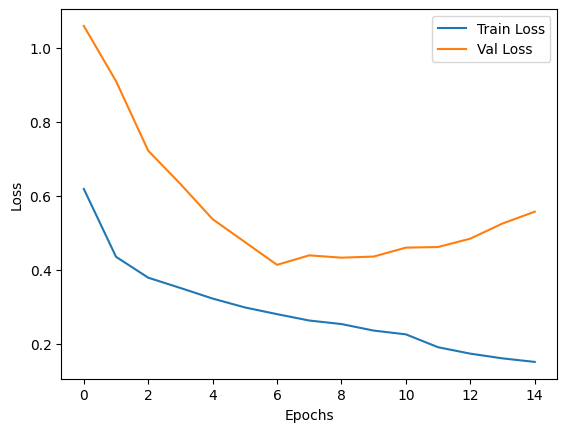

In [81]:
# plot learningn curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
CNN — Train
              precision    recall  f1-score   support

         0.0      0.957     0.728     0.827      2105
           2      0.924     0.917     0.920      1641
         3.0      0.856     0.972     0.911      5830
         4.0      0.838     0.671     0.745      1376

    accuracy                          0.879     10952
   macro avg      0.894     0.822     0.851     10952
weighted avg      0.883     0.879     0.875     10952



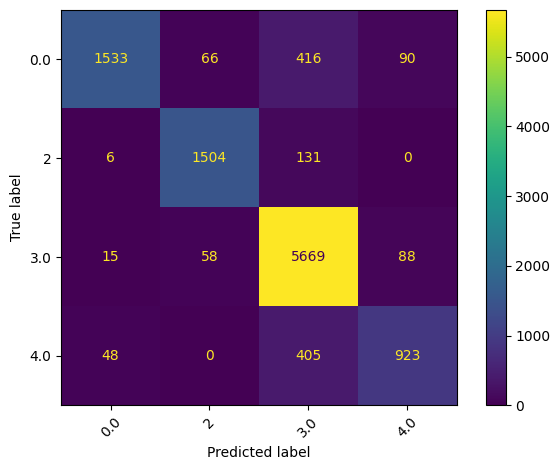

Stable gears (CNN) — Train
              precision    recall  f1-score   support

         0.0       0.99      0.76      0.86      1614
           2       0.95      0.98      0.96      1385
         3.0       0.90      0.99      0.94      5095
         4.0       0.91      0.75      0.83       867

    accuracy                           0.92      8961
   macro avg       0.94      0.87      0.90      8961
weighted avg       0.93      0.92      0.92      8961



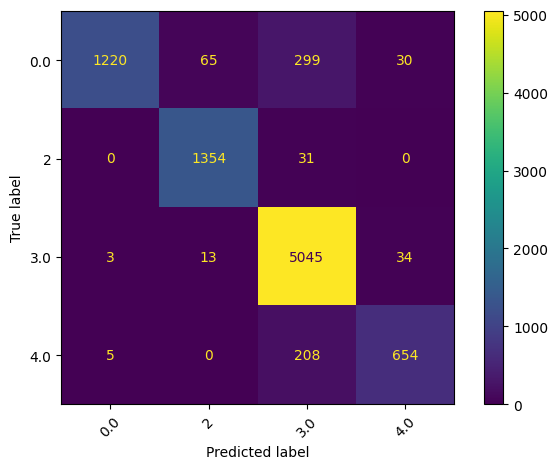

CNN — Test
              precision    recall  f1-score   support

         0.0      0.768     0.795     0.782       533
           2      0.634     0.883     0.738       402
         3.0      0.853     0.818     0.835      1473
         4.0      0.671     0.433     0.527       330

    accuracy                          0.777      2738
   macro avg      0.732     0.732     0.720      2738
weighted avg      0.782     0.777     0.773      2738



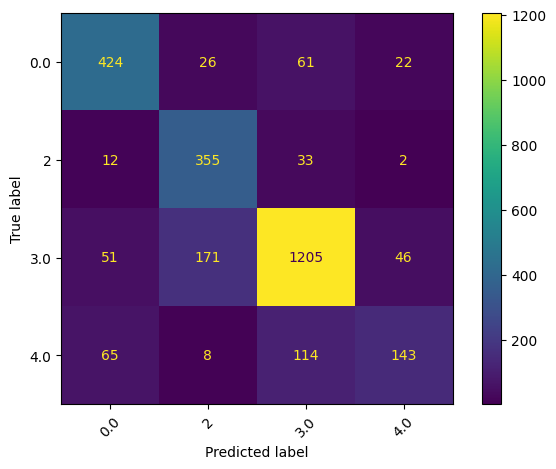

Stable gears (CNN) — Test
              precision    recall  f1-score   support

         0.0       0.94      0.78      0.86       258
           2       0.72      0.99      0.84       222
         3.0       0.94      0.92      0.93       938
         4.0       0.84      0.72      0.78        87

    accuracy                           0.89      1505
   macro avg       0.86      0.85      0.85      1505
weighted avg       0.91      0.89      0.90      1505



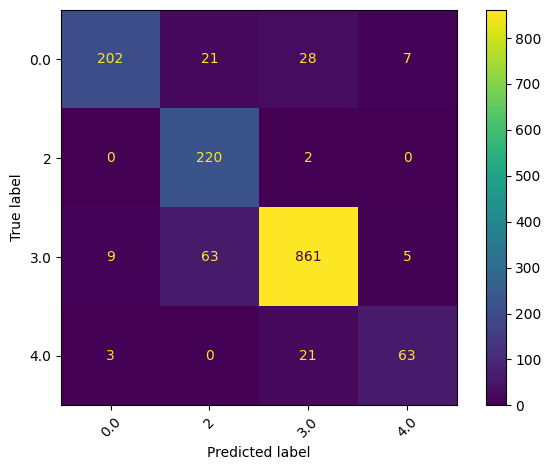

In [82]:
ALL_LABELS = sorted(y_train.unique())

proba_test = model.predict(X_test_seq)
pred_test  = np.argmax(proba_test, axis=1)
pred_test_labels = le.inverse_transform(pred_test)

proba_train = model.predict(X_train_seq)
pred_train  = np.argmax(proba_train, axis=1)
pred_train_labels = le.inverse_transform(pred_train)

print("CNN — Train")
print(classification_report(y_train_seq, pred_train_labels, digits=3))

cm = confusion_matrix(y_train_seq, pred_train_labels, labels=le.classes_)
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(xticks_rotation=45)
plt.tight_layout(); plt.show()

# “Stable gear” on the window-end labels:
print("Stable gears (CNN) — Train")
print(classification_report_when_stable_gear(pd.Series(y_train_seq), pred_train_labels))
cm_stable, labels = confusion_matrix_when_stable_gear(pd.Series(y_train_seq), pred_train_labels), le.classes_
ConfusionMatrixDisplay(cm_stable, display_labels=labels).plot(xticks_rotation=45)
plt.tight_layout(); plt.show()

print("CNN — Test")
print(classification_report(y_test_seq, pred_test_labels, digits=3))

cm = confusion_matrix(y_test_seq, pred_test_labels, labels=le.classes_)
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(xticks_rotation=45)
plt.tight_layout(); plt.show()

# “Stable gear” on the window-end labels:
print("Stable gears (CNN) — Test")
print(classification_report_when_stable_gear(pd.Series(y_test_seq), pred_test_labels))
cm_stable, labels = confusion_matrix_when_stable_gear(pd.Series(y_test_seq), pred_test_labels), le.classes_
ConfusionMatrixDisplay(cm_stable, display_labels=labels).plot(xticks_rotation=45)
plt.tight_layout(); plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step


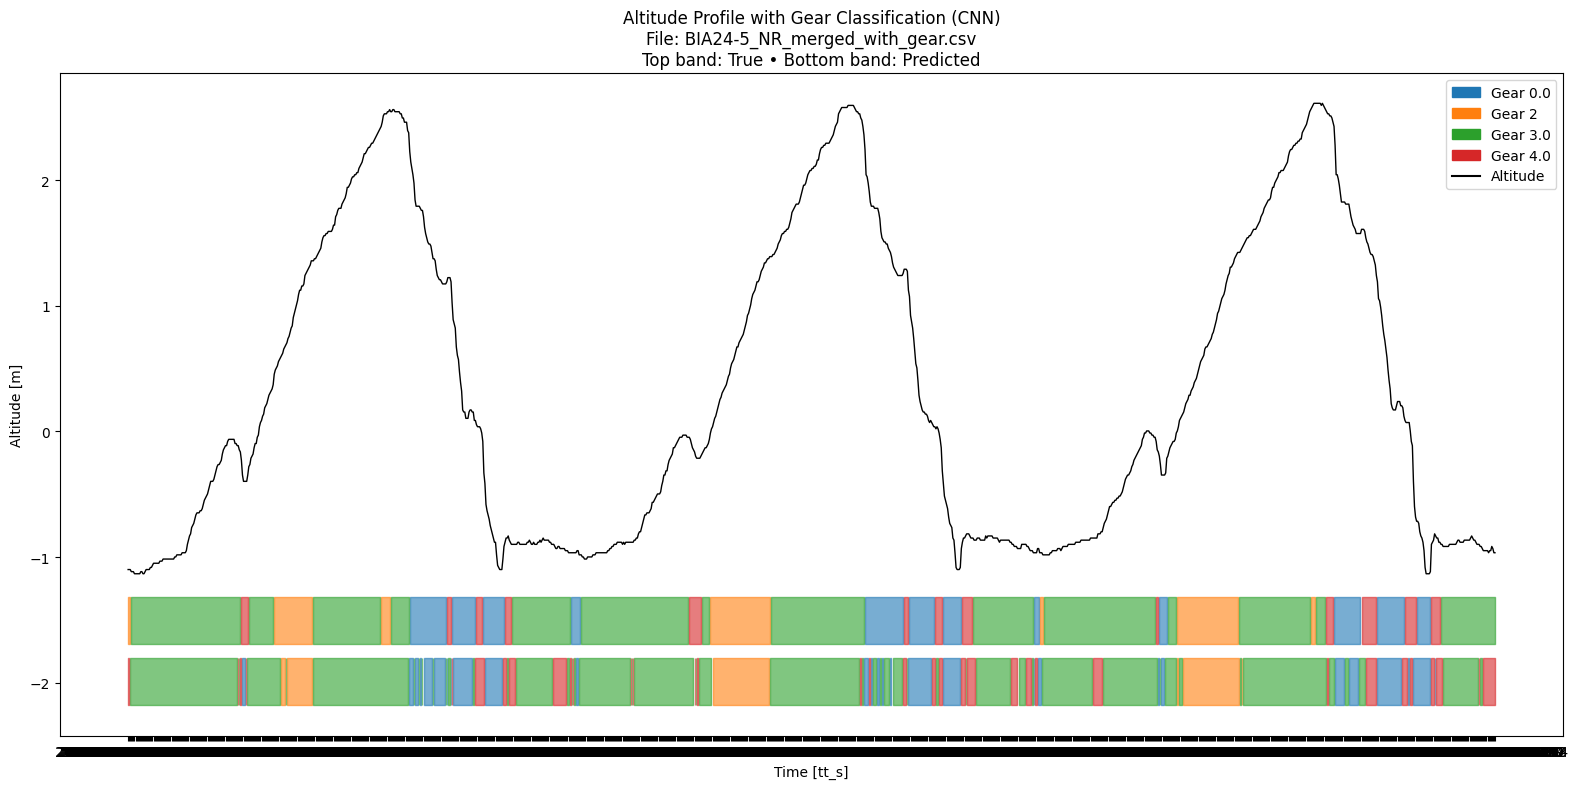

In [51]:
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Choose a single test file
# -----------------------------
i = 1  # index of test file you want to plot
df_plot = test_dfs[i].copy()

# Ensure numeric types etc. (same as training)
df_plot = make_sure_numeric(df_plot, feature_columns_pole_data + feature_columns_gnss)

# Sort by time just to be safe
if 'tt_s' in df_plot.columns:
    df_plot = df_plot.sort_values('tt_s').reset_index(drop=True)

# -----------------------------
# Features, labels, and windows
# -----------------------------
X_file = df_plot[feature_columns]
y_file = df_plot[output_col]              # original gear labels (strings or numbers)

# Build CNN input windows (same window_size you used for training, here 5)
window_size = 5
X_file_seq, y_file_seq = make_window_for_cnn(X_file.values, y_file, window_size=window_size)
# make_window_for_cnn returns one window per original timestep, so lengths match

# CNN predictions: probabilities -> integer classes -> original labels
proba_file = model.predict(X_file_seq)
pred_int = np.argmax(proba_file, axis=1)
pred_labels = le.inverse_transform(pred_int)  # back to gear labels

# Convert to string arrays for plotting
true_str = pd.Series(y_file_seq).astype(str).values
pred_str = pd.Series(pred_labels).astype(str).values

# -----------------------------
# Prepare time and altitude
# -----------------------------
if 'tt_s' in df_plot.columns:
    t = df_plot['tt_s'].values
    x_label = "Time [tt_s]"
else:
    t = df_plot.index.values
    x_label = "Frame index"

alt = df_plot['ns1:AltitudeMeters'].values

# Make sure all arrays have same length
min_len = min(len(t), len(alt), len(true_str), len(pred_str))
t = t[:min_len]
alt = alt[:min_len]
true_str = true_str[:min_len]
pred_str = pred_str[:min_len]

unique_classes_str = sorted(np.unique(true_str))

# -----------------------------
# Plot altitude + gear bands
# -----------------------------
cmap = plt.get_cmap("tab10")
class_to_color = {cls: cmap(i) for i, cls in enumerate(unique_classes_str)}

plt.figure(figsize=(16, 8))

# Altitude curve
plt.plot(t, alt, color='black', linewidth=1, label="Altitude", zorder=10)

y_min, y_max = alt.min(), alt.max()
y_range = y_max - y_min if y_max > y_min else 1.0

true_band_top = y_min - 0.05 * y_range
true_band_bot = y_min - 0.15 * y_range
pred_band_top = y_min - 0.18 * y_range
pred_band_bot = y_min - 0.28 * y_range

# True gear band
for cls in unique_classes_str:
    mask = (true_str == cls)
    if np.any(mask):
        plt.fill_between(
            t, true_band_bot, true_band_top,
            where=mask,
            color=class_to_color[cls],
            alpha=0.6,
            step='mid'
        )

# Predicted gear band
for cls in unique_classes_str:
    mask = (pred_str == cls)
    if np.any(mask):
        plt.fill_between(
            t, pred_band_bot, pred_band_top,
            where=mask,
            color=class_to_color[cls],
            alpha=0.6,
            step='mid'
        )

# Legend & labels
handles = [mpatches.Patch(color=class_to_color[c], label=f"Gear {c}")
           for c in unique_classes_str]
handles.append(plt.Line2D([], [], color='black', label='Altitude'))

plt.xlabel(x_label)
plt.ylabel("Altitude [m]")
plt.title(
    "Altitude Profile with Gear Classification (CNN)\n"
    f"File: {test_files[i].name}\nTop band: True • Bottom band: Predicted"
)
plt.legend(handles=handles, loc="upper right")
plt.tight_layout()
plt.show()


In [50]:
# evaluate trained model on individual skiers and print per skier results:
train_ind_dir = Path("../datasets/NR_split_on_skiers/train_val") 
train_ind_files = list(train_ind_dir.glob("*.csv"))
print(f"Training files: {len(train_ind_files)}")

test_ind_dir = Path("../datasets/NR_split_on_skiers/test")
test_ind_files = list(test_ind_dir.glob("*.csv"))

from sklearn.metrics import accuracy_score, classification_report

print("\n=== PER-SKIER TRAINING EVALUATION ===")

for file in train_ind_files:
    # Load and prepare file
    df = load_data(file)
    df = make_sure_numeric(df, feature_columns_gnss + feature_columns_pole_data)
    df['Variant'] = df['Variant'].map({'NR': 0, 'WR': 1})

    # Extract features and labels
    X_file = df[feature_columns]
    y_file = df[output_col]

    # Predict
    pred_file = rf_tuned.predict(X_file)

    # Compute accuracy
    acc = accuracy_score(y_file, pred_file)

    print(f"\nFile: {file.name}")
    print(f"  Samples: {len(df)}")
    print(f"  Accuracy: {acc:.3f}")

    # Optional: add a confusion matrix or classification report
    # print(classification_report(y_file, pred_file, digits=3))
print("\n=== PER-SKIER TESTING EVALUATION ===")

for file in test_ind_files:
    # Load and prepare file
    df = load_data(file)
    df = make_sure_numeric(df, feature_columns_gnss + feature_columns_pole_data)
    df['Variant'] = df['Variant'].map({'NR': 0, 'WR': 1})

    # Extract features and labels
    X_file = df[feature_columns]
    y_file = df[output_col]

    # Predict
    pred_file = rf_tuned.predict(X_file)

    # Compute accuracy
    acc = accuracy_score(y_file, pred_file)

    print(f"\nFile: {file.name}")
    print(f"  Samples: {len(df)}")
    print(f"  Accuracy: {acc:.3f}")

    # Optional: add a confusion matrix or classification report
    # print(classification_report(y_file, pred_file, digits=3))


Training files: 10

=== PER-SKIER TRAINING EVALUATION ===


KeyError: "['incline'] not in index"